In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

/opt/homebrew/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


##### Pull in dataset for testing

In [2]:
df = pd.read_csv("https://gist.githubusercontent.com/ryanorsinger/19bc7eccd6279661bd13307026628ace/raw/e4b5d6787015a4782f96cad6d1d62a8bdbac54c7/lemonade.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         365 non-null    object 
 1   Day          365 non-null    object 
 2   Temperature  365 non-null    float64
 3   Rainfall     365 non-null    float64
 4   Flyers       365 non-null    int64  
 5   Price        365 non-null    float64
 6   Sales        365 non-null    int64  
dtypes: float64(3), int64(2), object(2)
memory usage: 20.1+ KB


In [17]:
df.head()

,Date,Day,Temperature,Rainfall,Flyers,Price,Sales
0,1/1/17,Sunday,27.0,2.00,15,0.5,10
1,1/2/17,Monday,28.9,1.33,15,0.5,13
2,1/3/17,Tuesday,34.5,1.33,27,0.5,15
3,1/4/17,Wednesday,44.1,1.05,28,0.5,17
4,1/5/17,Thursday,42.4,1.00,33,0.5,18


In [18]:
df.describe()

,Temperature,Rainfall,Flyers,Price,Sales
count,365.000000,365.000000,365.000000,365.0,365.000000
mean,61.224658,0.825973,40.104110,0.5,27.865753
std,18.085892,0.273890,13.786445,0.0,30.948132
min,15.100000,0.400000,-38.000000,0.5,7.000000
25%,49.700000,0.650000,31.000000,0.5,20.000000
50%,61.100000,0.740000,39.000000,0.5,25.000000
75%,71.700000,0.910000,49.000000,0.5,30.000000
max,212.000000,2.500000,80.000000,0.5,534.000000


##### Create a function that gets IQR bounds 
- Instead of "get_lower_and_upper_bounds" will be called "get_iqr_bounds"
- Takes Dataframes instead of Series

In [13]:
def get_iqr_outlier_bounds(data,multiplier=1.5,include=None,exclude=None):
    """
    Returns dataframe with list of columns and the upper and lower bounds using the IQR method:
        LB = Q1 - multiplier * IQR
        UB = Q3 + multiplier * IQR
    If no columns passed to include or exclude, it defaults to finding outliers for all columns.
    Function will ignore non-numeric columns.
    
    Returns: 
        If provided Dataframe: Returns Pandas Dataframe with "lower_bound" and "upper_bound"
           If provided Series: Returns Tuple - lower bound, then upper bound
        
    Parameters:
          data: Pandas dataframe or Pandas Series
    multiplier: multiplier to determine level of outliers to find (mild to extreme).  Default = 1.5
       include: list of columns to find outliers for
        excude: list of columns to NOT find outliers for.  Ignored if 'include'is set.   
    
    C88
    """
    #If passed a dataframe - 
    if isinstance(data,pd.DataFrame):
        #Get Column List
        #if include and exclude are None
        if not include and not exclude:
            columns = data.columns #returns index - iterable
        elif include:
            columns = include
        else: columns = exclude
            
        #Only pull out numeric columns
        columns = data[columns].select_dtypes(include='number')

        #create df for bounds
        bounds = pd.DataFrame()
        #for each column, 
        for col in columns:
            #find bounds for this column
            lb, ub = get_lower_and_upper_bounds(data[col],multiplier=multiplier)
            #add to bounds dataframe
            bounds.loc['lower_bound',col] = lb
            bounds.loc['upper_bound',col] = ub
        return bounds
    elif isinstance(data,pd.Series):
        return get_lower_and_upper_bounds(data,multiplier=multiplier)

def get_lower_and_upper_bounds(dataseries,multiplier=1.5):
    '''
    Returns lower and upper bounds of a seriesusing the IQR method:
        LB = Q1 - multiplier * IQR
        UB = Q3 + multiplier * IQR
        
    Returns: Tuple - lower bound, then upper bound
        
    Parameters:
          data: Pandas Series
    multiplier: multiplier to determine level of outliers to find (mild to extreme).  Default = 1.5
       
    '''
    q1, q3 = dataseries.quantile([.25,.75])
    iqr = q3 - q1
    lb = q1 - (multiplier * iqr)
    ub = q3 + (multiplier * iqr)
    return lb, ub

In [31]:
def trim_iqr_outliers(df,bounds):
    """
    Takes in the dataset dataframe, and dataframe of the bounds for each column to be trimmed.
    Returns: Trimmed dataframe
    """
    #loop over columns to work on
    for col in bounds.columns:
        #for each col, grab the outliers
        lb = bounds.loc['lower_bound',col]
        ub = bounds.loc['upper_bound',col]
        #create smaller df of only rows where column is in bounds
        df = df[(df[col] >= lb) & (df[col]<=ub)]
    return df

def calc_outliers(x,lb,ub):
    ''''
    Given a value, determines if it is between the provided upper and lower bounds.  
    If b/w bounds, returns 0, else returns the distance outside of the bounds
    '''
    #if not an outlier, set to zero
    if lb <= x <= ub: return 0
    elif x < lb: return x-lb
    else: return x-ub

def add_outlier_columns(df,bounds):
    #loop over columns in bounds
    for col in bounds.columns:
        #new column name
        col_name = col + '_outlier'
        #for each column, apply the outlier calculation and store to new column
        df[col_name] = df[col].apply(calc_outliers,args=(bounds.loc['lower_bound',col],bounds.loc['upper_bound',col]))
    return df


def handle_iqr_outliers(old_df,trim=False,multiplier=1.5,include=None,exclude=None):
    """
    Takes in a dataframe and either trims outliers or creates column identifying outliers. 
    
    Outputs: None
    Returns: Pandas Dataframe
    Parameters:
                   df: dataframe in which to find outliers
                 trim: If True, will trim out any rows that contain any outliers.  
                        If False, creates new columns to indicate if row is an outlier or not.
                        Default: False
      include/exclude: list of columns to include or exclude for this function.  
                       Default is all, exclude will be ignored if include is provided.
    C88
    """    
    df= old_df.copy()    
    #Get bounds dataframe
    bounds = get_iqr_outlier_bounds(df,multiplier,include,exclude)

    #If we want new column 
    if trim:
        #Function trims row if value not w/i bounds
        df = trim_iqr_outliers(df,bounds)
    else:
        #function determines if outlier and adds new columnadds new columns 
        df = add_outlier_columns(df,bounds)
        
    return df

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         365 non-null    object 
 1   Day          365 non-null    object 
 2   Temperature  365 non-null    float64
 3   Rainfall     365 non-null    float64
 4   Flyers       365 non-null    int64  
 5   Price        365 non-null    float64
 6   Sales        365 non-null    int64  
dtypes: float64(3), int64(2), object(2)
memory usage: 20.1+ KB


In [15]:
get_lower_and_upper_bounds(df.Temperature)

(16.700000000000003, 104.7)

##### Get lower and upper outliers of lemonade data using 1.5 multiplier

In [16]:
get_iqr_outlier_bounds(df)

,Temperature,Rainfall,Flyers,Price,Sales
lower_bound,16.7,0.26,4.0,0.5,5.0
upper_bound,104.7,1.30,76.0,0.5,45.0


In [34]:
find_outliers = handle_iqr_outliers(df,trim=False)
find_outliers

,Date,Day,Temperature,Rainfall,Flyers,Price,Sales,Temperature_outlier,Rainfall_outlier,Flyers_outlier,Price_outlier,Sales_outlier
0,1/1/17,Sunday,27.0,2.00,15,0.5,10,0.0,0.70,0.0,0,0.0
1,1/2/17,Monday,28.9,1.33,15,0.5,13,0.0,0.03,0.0,0,0.0
2,1/3/17,Tuesday,34.5,1.33,27,0.5,15,0.0,0.03,0.0,0,0.0
3,1/4/17,Wednesday,44.1,1.05,28,0.5,17,0.0,0.00,0.0,0,0.0
4,1/5/17,Thursday,42.4,1.00,33,0.5,18,0.0,0.00,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
360,12/27/17,Wednesday,42.7,1.00,33,0.5,19,0.0,0.00,0.0,0,0.0
361,12/28/17,Thursday,37.8,1.25,32,0.5,16,0.0,0.00,0.0,0,0.0
362,12/29/17,Friday,39.5,1.25,17,0.5,15,0.0,0.00,0.0,0,0.0
363,12/30/17,Saturday,30.9,1.43,22,0.5,13,0.0,0.13,0.0,0,0.0


In [41]:
find_outliers.Temperature[find_outliers.Temperature_outlier != 0]

41     212.0
364     15.1
Name: Temperature, dtype: float64

In [42]:
find_outliers.Rainfall[find_outliers.Rainfall_outlier != 0]

0      2.00
1      1.33
2      1.33
5      1.54
6      1.54
10     1.54
11     1.33
12     1.33
15     1.67
16     1.43
19     1.43
23     1.54
27     1.33
28     1.33
337    1.54
338    1.82
342    1.43
343    1.82
345    1.33
346    1.43
347    1.54
350    1.33
351    1.43
354    1.33
355    1.54
359    1.43
363    1.43
364    2.50
Name: Rainfall, dtype: float64

In [38]:
find_outliers.Flyers[find_outliers.Flyers_outlier != 0]

,Date,Day,Temperature,Rainfall,Flyers,Price,Sales,Temperature_outlier,Rainfall_outlier,Flyers_outlier,Price_outlier,Sales_outlier
166,6/16/17,Friday,99.3,0.47,77,0.5,41,0.0,0.0,1.0,0,0.0
194,7/14/17,Friday,92.0,0.50,80,0.5,40,0.0,0.0,4.0,0,0.0
324,11/21/17,Tuesday,47.0,0.95,-38,0.5,20,0.0,0.0,-42.0,0,0.0


In [43]:
find_outliers.Price[find_outliers.Price_outlier != 0]

Series([], Name: Price, dtype: float64)

In [45]:
find_outliers.Sales[find_outliers.Sales_outlier != 0]

181    143
182    158
183    235
184    534
Name: Sales, dtype: int64

By just looking at these outliers, I wouldn't necessarily get rid of everything. We can definitely get rid of the 200+ degree temperature.  The Rain seems fine, the price has no outliers.  The Flyers have a negative value that can be thrown out.  The Sales have some high values, but I wouldn't necessarily throw them out without looking at the rest of the data for those days.

##### Get bounds using a multiplier of 3

In [20]:
get_iqr_outlier_bounds(df,multiplier=3)

,Temperature,Rainfall,Flyers,Price,Sales
lower_bound,-16.3,-0.13,-23.0,0.5,-10.0
upper_bound,137.7,1.69,103.0,0.5,60.0


In [59]:
find_outliers = handle_iqr_outliers(df,multiplier=3,trim=False)
find_outliers.head()

,Date,Day,Temperature,Rainfall,Flyers,Price,Sales,Temperature_outlier,Rainfall_outlier,Flyers_outlier,Price_outlier,Sales_outlier
0,1/1/17,Sunday,27.0,2.00,15,0.5,10,0.0,0.31,0.0,0,0.0
1,1/2/17,Monday,28.9,1.33,15,0.5,13,0.0,0.00,0.0,0,0.0
2,1/3/17,Tuesday,34.5,1.33,27,0.5,15,0.0,0.00,0.0,0,0.0
3,1/4/17,Wednesday,44.1,1.05,28,0.5,17,0.0,0.00,0.0,0,0.0
4,1/5/17,Thursday,42.4,1.00,33,0.5,18,0.0,0.00,0.0,0,0.0


In [54]:
find_outliers.Temperature[find_outliers.Temperature_outlier != 0]

41    212.0
Name: Temperature, dtype: float64

In [55]:
find_outliers.Rainfall[find_outliers.Rainfall_outlier != 0]

0      2.00
338    1.82
343    1.82
364    2.50
Name: Rainfall, dtype: float64

In [56]:
find_outliers.Flyers[find_outliers.Flyers_outlier != 0]

324   -38
Name: Flyers, dtype: int64

In [57]:
find_outliers.Price[find_outliers.Price_outlier != 0]

Series([], Name: Price, dtype: float64)

In [58]:
find_outliers.Sales[find_outliers.Sales_outlier != 0]

181    143
182    158
183    235
184    534
Name: Sales, dtype: int64

*Same as the 1.5.  Wouldn't necessarily get rid of all of this - notably the Rainfall and Sales.*

##### Identify if any columns are normally distributed

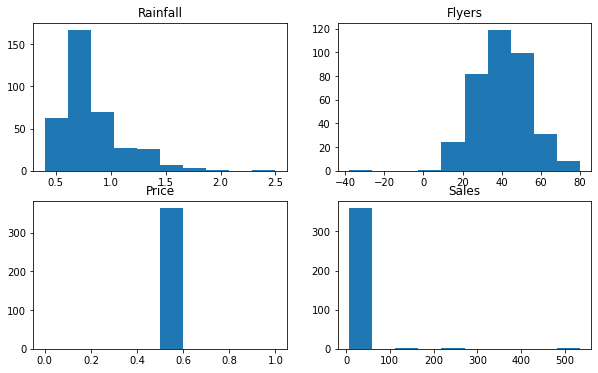

In [26]:
plt.figure(figsize=(10,6))
for cnt,c in enumerate(df.columns[-4:]):
    plt.subplot(2,2,cnt+1)
    plt.hist(df[c])
    plt.title(c)

The Flyers column is normally distributed

##### Look at 2 and 3 sigma rule to find the outliers

In [61]:
df.Flyers[abs(df.Flyers - df.Flyers.mean())/df.Flyers.std() > 2]

166    77
170    70
171    76
182    68
183    68
194    80
198    76
203    72
204    69
207    74
324   -38
338    11
364     9
Name: Flyers, dtype: int64

In [62]:
df.Flyers[abs(df.Flyers - df.Flyers.mean())/df.Flyers.std() > 3]

324   -38
Name: Flyers, dtype: int64

I wouldn't throw out all the outliers on the 2 sigma rule as it contains a lot of good data (which is to be expected as there are still 5% of values)

I would throw out the > 3 sigma data as it is clearly bad data